# Visualize Data #
Visualize correlations between nodes

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [4]:
print(dat['pupilCOM'].shape)

(7018, 2)


Text(0.5, 1.0, 'Pupil tracking')

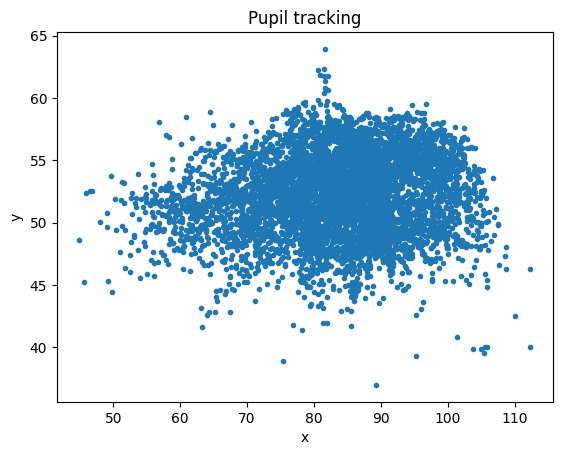

In [95]:
pupil_x_coords = dat['pupilCOM'][:,0]
pupil_y_coords = dat['pupilCOM'][:,1]
plt.plot(pupil_x_coords, pupil_y_coords, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Pupil tracking')

In [96]:
print((pupil_x_coords < 80).sum())
print(len(pupil_x_coords))

2120
7018


## Building Graph Connectivity ##

In [85]:
import torch
from torch_geometric.data import Data
import networkx as nx

In [28]:
neuron_data = dat['sresp']

In [94]:
neuron_data.shape

(11983, 7018)

In [40]:
#Filter the neuron data with a backwards-looking window of 20 frames
frame_size = 20
neuron_data_filtered = scipy.ndimage.uniform_filter1d(neuron_data, frame_size, axis=-1, mode='nearest', origin=-frame_size//2)

In [79]:
corr_matrix = np.corrcoef(neuron_data_filtered).round(decimals=4)

In [42]:
corr_matrix.shape

(11983, 11983)

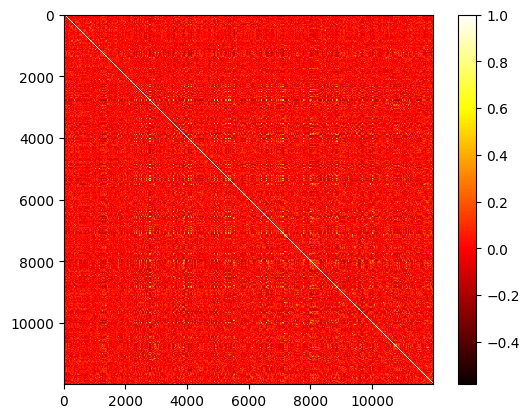

In [43]:
#Plot correlation matrix
plt.imshow(corr_matrix, cmap='hot', interpolation='nearest')
#Include colorbar
plt.colorbar()

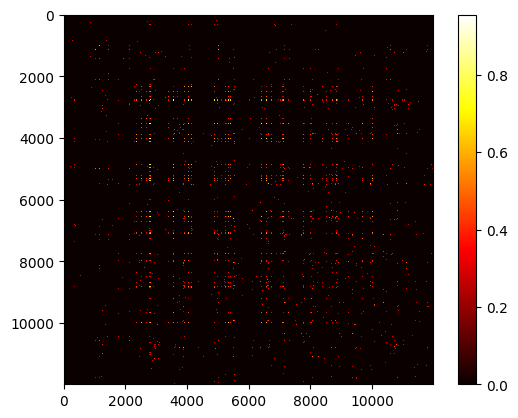

In [80]:
#Find the largest 2%, positive, non-diagonal correlations
corr_matrix[np.diag_indices_from(corr_matrix)] = 0
corr_matrix[corr_matrix < 0] = 0

# NOTE: Since the correlation matrix is symmetric, we must take the top 10% of the values
# in the entire matrix to get the top 10% of the connections
corr_matrix[corr_matrix < np.percentile(corr_matrix, 99)] = 0

plt.imshow(corr_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()

In [103]:
#Convert the correlation matrix to a list of graph edge connections in COO format
edges = np.nonzero(corr_matrix)
edge_index = torch.tensor(np.array([edges[0], edges[1]]), dtype=torch.long)

#Define the edge attributes as the correlation values between the neurons
edge_attr = torch.tensor(corr_matrix[edges], dtype=torch.float).unsqueeze(-1)

In [111]:
eligible_frames = np.where((pupil_x_coords < 75) | (pupil_x_coords > 85))[0]
print(pupil_x_coords[4])

90.89392566230129


In [117]:
#Define the node attributes as a vector containing the neuron's data for 20 preceding frames, including the current frame
frame_window = 20

#Find the frames where the pupil is looking either to the left or right and is greater than 20 frames from the beginning of the recording
eligible_frames = np.where((pupil_x_coords < 75) | (pupil_x_coords > 85))[0]
eligible_frames = eligible_frames[eligible_frames > frame_window]

curr_frame = eligible_frames[0]

#Extract the neuron indices from the edge connections
neuron_indices = np.unique(edges[0])

node_attr = torch.tensor(neuron_data[neuron_indices,curr_frame-frame_window:curr_frame+1], dtype=torch.float)

#Define the graph label as the current frame's direction of the pupil in the x direction
#If the x coordinate of the pupil is less than 75, the direction is left, denoted by 0
#If the x coordinate of the pupil is greater than 85, the direction is right, denoted by 1

curr_x_coord = pupil_x_coords[curr_frame]
if(curr_x_coord < 75):
  graph_label = torch.tensor([0], dtype=torch.long).unsqueeze(-1)
elif(curr_x_coord > 85):
    graph_label = torch.tensor([1], dtype=torch.long).unsqueeze(-1)
else:
    graph_label = torch.tensor([-1], dtype=torch.long).unsqueeze(-1)
    print("WARNING: Pupil located in the middle")

In [118]:
data = Data(x=node_attr, edge_index=edge_index, edge_attr=edge_attr, y=graph_label)

In [124]:
print(edge_index.shape)
print(node_attr.shape)

torch.Size([2, 1436288])
torch.Size([11372, 21])


In [123]:
#Find the average node degree
avg_degree = round(edge_index.shape[-1]/node_attr.shape[0])
print(avg_degree)

126


In [44]:
#Find the average and standard deviation of the positive values in the correlation matrix
avg_corr = np.mean(corr_matrix[corr_matrix > 0])
std_corr = np.std(corr_matrix[corr_matrix > 0])
#print(avg_corr, std_corr)

#Find the z-score of each value in the correlation matrix
z_score = (corr_matrix - avg_corr) / std_corr
#print(z_score.shape)

#Find the top 10% largest non-diagonal z-score values
z_score[np.diag_indices_from(z_score)] = 0
z_score = z_score.flatten()
z_score = np.sort(z_score)
z_score = z_score[int(len(z_score)*0.9):]
print(z_score)

[ 0.66513545  0.66513545  0.66513545 ... 12.67751275 12.68759992
 12.68759992]


In [26]:
print(z_score)

[ 0.26490881  0.26490881  0.26490881 ... 30.42112492 31.20440326
 31.20440326]
